<a href="https://colab.research.google.com/github/yuvalgrossman/DeepMoon/blob/master/DeepMoon_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
sys.version
!pip list

Package                            Version    
---------------------------------- -----------
absl-py                            0.7.1      
alabaster                          0.7.12     
anaconda-client                    1.7.2      
anaconda-navigator                 1.9.7      
anaconda-project                   0.8.2      
asn1crypto                         0.24.0     
astor                              0.7.1      
astroid                            2.2.5      
astropy                            3.1.2      
atomicwrites                       1.3.0      
attrs                              19.1.0     
Babel                              2.6.0      
backcall                           0.1.0      
backports.os                       0.1.1      
backports.shutil-get-terminal-size 1.0.0      
beautifulsoup4                     4.7.1      
bitarray                           0.8.3      
bkcharts                           0.2        
bleach                             3.1.0      
bokeh        

# **Installation**
(YG)

*1*. Import DeepMoon github repository and install the requirments: 

In [33]:
# !git clone https://github.com/yuvalgrossman/DeepMoon
# deepmoon_path='/content/DeepMoon/'
# sys.path.append(deepmoon_path)
# # print(sys.path)
# # !apt-get install libproj-dev proj-data proj-bin
# # !apt-get install libgeos-dev
# # !pip install cython
# # !pip install -r /content/DeepMoon/requirements.txt
# !apt-get -qq install python-cartopy python3-cartopy

# # play a sound when done installing: 
# import numpy as np
# from IPython.display import Audio
# framerate = 44100
# t = np.linspace(0,5,framerate*2)
# data = np.sin(2*np.pi*222*t)# + np.sin(2*np.pi*224*t)
# Audio(data,rate=framerate, autoplay=True)

In [2]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image    # Requires Pillow
import urllib
import cartopy

*2.* Mount google drive. Check if files exist and download to it the data from Zenodo if necessary:

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !mkdir gdrive/'My Drive'/DeepMoon
# !mkdir gdrive/'My Drive'/DeepMoon/zenodo_downloads/
# !ls --file-type 'gdrive/My Drive/DeepMoon/zenodo_downloads'
# zenodo_path = 'gdrive/My Drive/DeepMoon/zenodo_downloads/'
# zenodo_path_sh='gdrive/My\ Drive/DeepMoon/zenodo_downloads/'
data_path = '/mnt/disks/disk0/deep_moon_working_dir/data/Silburt/'
zenodo_path = data_path
# check if exist here and download data from Zenodo: 
Files = ["dev_craters.hdf5", # - Pandas HDFStore of crater locations and sizes for images in the validation dataset.
         "dev_images.hdf5", # - Input DEM images and output targets of the validation dataset.  Also includes each image's longitude/latitude bounds, and the pixel bounds of the global DEM regions cropped to make each image.
         "LunarLROLrocKaguya_118mperpix.png", # - LRO LOLA and Kaguya Terrain Camera DEM Merge, downsampled to 118 m/pixel and 8 bits/pixel.  The original file can be found at: https://astrogeology.usgs.gov/search/map/Moon/LRO/LOLA/Lunar_LRO_LrocKaguya_DEMmerge_60N60S_512ppd.
         "model_keras1.2.2.h5", # - Keras model weights for the DeepMoon CNN, compatible with Keras version 1.2.2.
         "model_keras2.h5", # - Keras model weights for the DeepMoon CNN, compatible with Keras versions >= 2.0.
         "post-processed_sample_images.zip", # - Contains a set of sample images from the test dataset with the Moon DEM image, new identified craters, CNN target predictions, and ground-truth. The new craters from these images were used to estimate the post-processed false positive rate. See Instructions.txt in .zip file for more details.
         "post-processed_test_craters.npy", # - numpy file containing post-processed craters identified by our pipeline on the test set. Each crater entry is arranged as a tuple: (longitude, latitude, radii), where longitude and latitude are in degrees, and radius is in kilometres. 
         "test_craters.hdf5", # - Pandas HDFStore of crater locations and sizes for images in the test dataset.
         "test_images.hdf5", # - Input DEM images and output targets of the test dataset.  Also includes each image's longitude/latitude bounds, and the pixel bounds of the global DEM regions cropped to make each image.
         "train_craters.hdf5", # - Pandas HDFStore of crater locations and sizes for images in the training dataset.
         "train_images.hdf5"] # - Input DEM images and output targets of the training dataset.  Also includes each image's longitude/latitude bounds, and the pixel bounds of the global DEM regions cropped to make each image.]

for file in Files: 
  if os.path.isfile(zenodo_path+file): 
    print('File {} exist in library!'.format(file))
  else: 
    print('File {} does not exist in library. downloading now from Zenodo ...'.format(file))
    URL = "https://zenodo.org/record/1133969/files/"+file
    !wget -P "$zenodo_path_sh" "$URL"
    print('Downloaded into {}'.format(zenodo_path+file))

File dev_craters.hdf5 exist in library!
File dev_images.hdf5 exist in library!
File LunarLROLrocKaguya_118mperpix.png exist in library!
File model_keras1.2.2.h5 exist in library!
File model_keras2.h5 exist in library!
File post-processed_sample_images.zip exist in library!
File post-processed_test_craters.npy exist in library!
File test_craters.hdf5 exist in library!
File test_images.hdf5 exist in library!
File train_craters.hdf5 exist in library!
File train_images.hdf5 exist in library!


# HDF5 Datasets

## Image Datasets

The training, validation and testing DEM images and target masks used to train and evaluate the DeepMoon model are found in `train_images.hdf5`, `dev_images.hdf5` and `test_images.hdf5`, respectively.  Also included in the files are each image's longitude/latitude bounds, which are used to post-process DeepMoon's crater detections.

These data can be read in using `h5py`.  Let's read in the `train_images.hdf5` data:

In [5]:
train_imgs = h5py.File(zenodo_path + '/train_images.hdf5', 'r')
print(type(train_imgs))

<class 'h5py._hl.files.File'>


Input images are 256 x 256 8-bit greyscale images, and target masks are 256 x 256 float arrays whose values fall between 0 and 1.  30000 inputs and targets are stored in the HDF5 file as two 30000 x 256 x 256 arrays; inputs can be found under the `'input_images'` entry, and targets under `'target_masks'`.  A target mask represents the ground truth crater locations of the input with the same image number (first array dimension).  Let's plot one input-target pair as an example (and set `vmin` and `vmax` to increase contrast of the input):

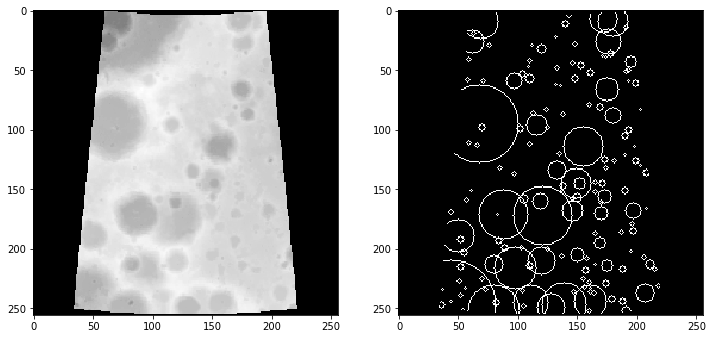

In [6]:
fig = plt.figure(figsize=[12, 6])
[ax1, ax2] = fig.subplots(1,2)
ax1.imshow(train_imgs['input_images'][100][...], origin='upper', cmap='Greys_r') #, vmin=50, vmax=150
ax2.imshow(train_imgs['target_masks'][100][...], origin='upper', cmap='Greys_r')
plt.show()

The longitude and latitude bounds of the input image can be found under `'longlat_bounds'`.  Here, instead of a 30000-element array, long/lat bounds are indexed by `'img_xxxxx'`, where xxxxx is the (zero-padded) image number, so the 4th image's boundaries are:

In [7]:
# a=train_imgs['target_masks'][100][...]
# a1 = a.reshape(a.shape[0]*a.shape[1],1)
# np.unique(a1)
#print(a1.unique)
#plt.hist(a1[:],bins=1000)
#plt.show()
#print 

In [8]:
print(type(train_imgs))
print(train_imgs['longlat_bounds']['img_00100'][...])

<class 'h5py._hl.files.File'>
[-145.921875  -130.0703125   42.1328125   57.984375 ]


The definitions of these numbers is under the "definition" attribute for the entry:

In [9]:
train_imgs['longlat_bounds'].attrs['definition']

'(long min, long max, lat min, lat max) of the cropped image.'

Other entries in the HDF5 are to correct for image distortion during post-processing, or are unused in the current pipeline.  Each entry in the HDF5 has definition metadata under its `.attrs['definition']` attribute.

In [10]:
print(train_imgs['pix_bounds'].attrs['definition'])
x1,x2,y1,y2=train_imgs['pix_bounds']['img_00200'][...]
print(x1,x2,y1,y2)

Pixel bounds of the Global DEM region that was cropped for the image.
2939 14491 3439 14991


In [11]:
print(list(train_imgs.keys()))
[print("{} : {}".format(x,train_imgs[x].attrs['definition'])) for x in list(train_imgs.keys())]
#train_imgs['input_images'].attrs['definition']

['cll_xy', 'input_images', 'longlat_bounds', 'pix_bounds', 'pix_distortion_coefficient', 'target_masks']
cll_xy : (x, y) pixel coordinates of the central long / lat.
input_images : Input image dataset.
longlat_bounds : (long min, long max, lat min, lat max) of the cropped image.
pix_bounds : Pixel bounds of the Global DEM region that was cropped for the image.
pix_distortion_coefficient : Distortion coefficient due to projection transformation.
target_masks : Target mask dataset.


[None, None, None, None, None, None]


## Plot images frames in the global context: 
(YG)
first download a global map of the moon, then randomly choose 5 images (out of 30,000) from each set (train, validation and test) and show their frames on the global map

In [20]:

!mkdir maps
# download albedo map: 
# ! wget -P DeepMoon/maps/ http://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/lola_gdr/cylindrical/jp2/ldam_4.jp2
! wget -P maps/ https://upload.wikimedia.org/wikipedia/commons/e/ea/Clementine_albedo_simp750.jpg
albedo = Image.open("maps/Clementine_albedo_simp750.jpg")
type(albedo)

mkdir: cannot create directory ‘maps’: File exists
--2019-06-27 08:56:23--  https://upload.wikimedia.org/wikipedia/commons/e/ea/Clementine_albedo_simp750.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209090 (204K) [image/jpeg]
Saving to: ‘maps/Clementine_albedo_simp750.jpg.1’

Clementine_albedo_s 100%[===================>] 204.19K   897KB/s    in 0.2s    

2019-06-27 08:56:23 (897 KB/s) - ‘maps/Clementine_albedo_simp750.jpg.1’ saved [209090/209090]



PIL.JpegImagePlugin.JpegImageFile

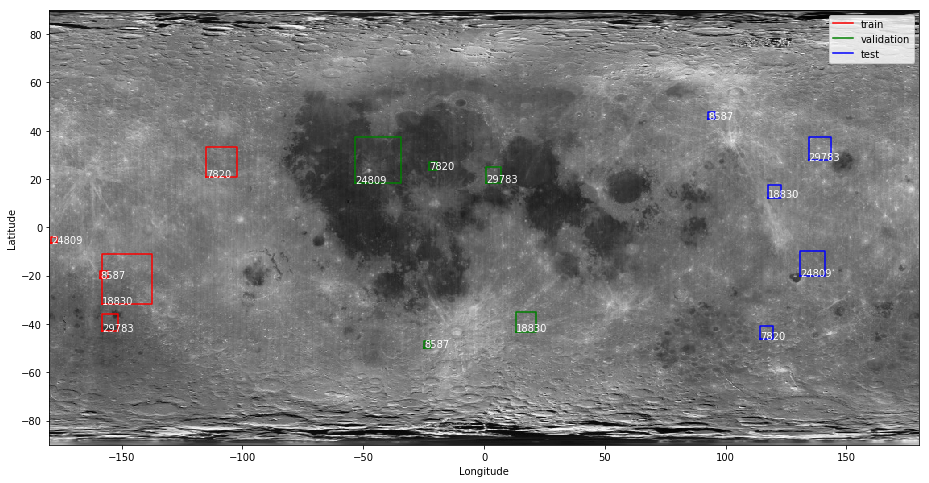

In [22]:
show_subset = np.random.choice(range(30000),size=5)

dev_imgs = h5py.File(zenodo_path + '/dev_images.hdf5', 'r')
test_imgs = h5py.File(zenodo_path + '/test_images.hdf5', 'r')

fig = plt.figure(figsize=[16, 8])
al_map = plt.imshow(albedo, extent=[-180, 180, -90, 90], aspect="equal", cmap="Greys_r")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
for i in show_subset:
  llon,rlon,llat,ulat=train_imgs['longlat_bounds']['img_{:05d}'.format(i)][...]
  h1,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'r')
  plt.text(llon,llat,str(i), color='w')
  
  llon,rlon,llat,ulat=dev_imgs['longlat_bounds']['img_{:05d}'.format(i)][...]
  h2,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'g')
  plt.text(llon,llat,str(i), color='w')
  
  llon,rlon,llat,ulat=test_imgs['longlat_bounds']['img_{:05d}'.format(i)][...]
  h3,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'b')
  plt.text(llon,llat,str(i), color='w')
  
  plt.legend((h1,h2,h3),('train','validation','test'))


Each image sample different size in order for the model to be size-independent. 

Note that each set is from different patch of the moon. note that the dark areas (termed Mare) are mostly in the validation set and not in the other two. The Mare has different character than the bright areas (termed Highlands) so this might affect the model. It might be better to divide each one of the Highlands and Mare to 3 sets. 

We now want to see these images, and the target mask over them: 

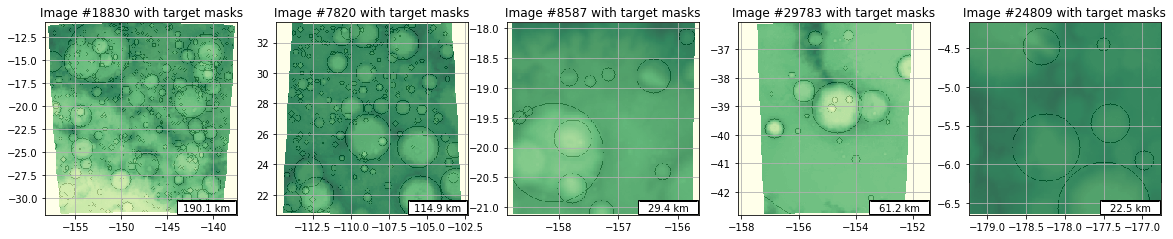

In [23]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
rmoon=1737 #km
kmperdeg = 2*np.pi*rmoon/360 # km per degree transformation

def plot_map_w_scalebar(ax,train_imgs,im_num):
  im_lims = train_imgs['longlat_bounds']['img_{:05d}'.format(im_num)][...] 
  #streching due to projection: 
#   d=np.diff(im_lims[:2])/np.cos(np.deg2rad(im_lims[2:].mean()))
#   im_lims[0]-=d/2;im_lims[1]+=d/2
  plt.imshow(train_imgs['input_images'][im_num][...], extent=im_lims, origin='upper', 
             cmap='YlGn', aspect='equal') #, vmin=50, vmax=150
  plt.imshow(1-train_imgs['target_masks'][im_num][...], alpha=0.2, extent=im_lims, 
             origin='upper', cmap='Greys_r', aspect='equal')
#   np.cos(np.deg2rad(im_lims[2:].mean()))
  plt.title('Image #{} with target masks'.format(im_num))
  l,r=plt.xlim()
  barlength = 0.3*(r-l)
  bartext = '{:2.1f} km'.format(barlength*kmperdeg)
  bar = AnchoredSizeBar(ax.transData, barlength, bartext, 4)
  ax.add_artist(bar)
  ax.grid()
  return im_lims

fig = plt.figure(figsize=[20, 12])
for i, im_num in enumerate(show_subset):
  ax=plt.subplot(len(show_subset)//5,5,i+1)
  plot_map_w_scalebar(ax,train_imgs,im_num)


Again, each image represents different area size, but all have been resized to 256x256 pix to feed the CNN. 

## Crater Tables

The ground truth crater data for the images is stored in Pandas HDFStore files `train_craters.hdf5`, `dev_craters.hdf5`, and `test_craters.hdf5` for the training, validation and testing data, respectively.  These tables are used for calculating accuracy metrics when tuning hyperparameters during training.  Let's read in the training ground truth:

In [24]:
ctrs = pd.HDFStore(zenodo_path + '/train_craters.hdf5', 'r')

Like the long/lat boundaries, crater dataframes are indexed by `'img_xxxxx'`, where xxxxx is the zero-padded image number for DEM images from `train_images.hdf5`.  The ground truth for image 3 is:

In [25]:
# (YG)
print('Crater list for image {}:'.format(im_num))
ctrs['img_{:05d}'.format(im_num)]

Crater list for image 24809:


,Diameter (km),Lat,Long,x,y,Diameter (pix)
0,36.564548,-6.567366,-177.496690,179.825981,247.517040,124.581625
1,7.420211,-5.949151,-176.983462,232.793046,183.713406,25.281920
2,26.304604,-5.779480,-178.245091,102.725082,166.100378,89.624254
3,15.018220,-5.476199,-177.421542,187.683566,134.787457,51.169626
4,14.908203,-4.484525,-178.302061,96.786846,32.306479,50.794780
5,5.338346,-4.460551,-177.513081,178.316566,29.842007,18.188651


Here, "Lat", "Long", and "Diameter (km)" are from the combined LROC-Head crater catalog, while "x", "y" and "Diameter (pix)" were derived from the former columns by the `input_data_gen.py` pipeline.

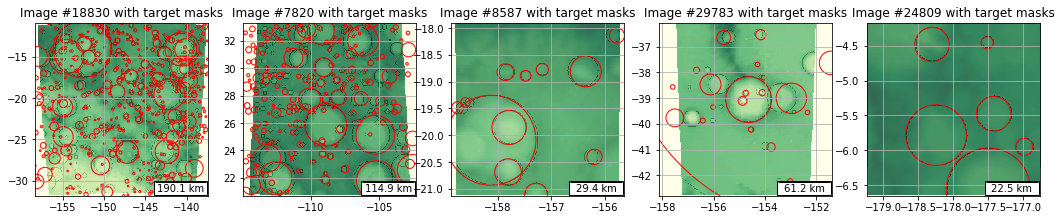

In [26]:
# (YG)
# plot craters from table on map: 
fig = plt.figure(figsize=[18, 9])
for i, im_num in enumerate(show_subset):
  ax=plt.subplot(len(show_subset)//5,5,i+1)
  im_lims=plot_map_w_scalebar(ax,train_imgs,im_num)
#    d=np.diff(im_lims[:2])/np.cos(np.deg2rad(im_lims[2:].mean()))
  for idx,crater in ctrs['img_{:05d}'.format(im_num)].iterrows():
    crater_patch = patches.Circle(np.array([crater['Long'],crater['Lat']]), 
                                   radius = crater['Diameter (km)']/(2*kmperdeg), fill=0, color='r')
    ax.add_artist(crater_patch)
#     print((256-crater['x'])/256)
#     print(crater['Lat'],(im_lims[1]-crater['Long'])/np.diff(im_lims[:2]))

(YG) *The* craters list coordinates seems to be shifted somehow, especially in the higher latitudes. 
This is probably related to projection of the maps. Lets look on the same maps presented without coordinates: 


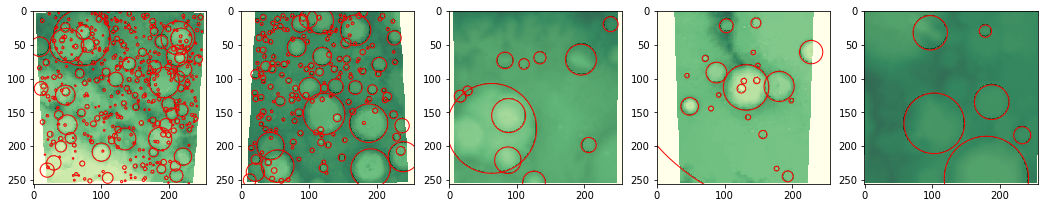

In [27]:
fig = plt.figure(figsize=[18, 9])
for i, im_num in enumerate(show_subset):
  ax2=plt.subplot(len(show_subset)//5,5,i+1)
  plt.imshow(train_imgs['input_images'][im_num][...], origin='upper', cmap='YlGn', aspect='equal') 
  plt.imshow(1-train_imgs['target_masks'][im_num][...], alpha=0.2, origin='upper', cmap='Greys_r')
  for idx,crater in ctrs['img_{:05d}'.format(im_num)].iterrows():
    crater_patch = patches.Circle(np.array([crater['x'],crater['y']]),radius = crater['Diameter (pix)']/(2), fill=0, color='r')
    ax2.add_artist(crater_patch)

It's ok that way. I think the problem is that when i present the maps in their coordinates, its only without the projection. 

# Lunar DEM
LunarLROLrocKaguya_118mperpix.png is the LRO LOLA and Kaguya Terrain Camera DEM Merge, downsampled to 118 m/pixel and 8 bits/pixel. It is combined with the LROC-Head combined crater catalogue by the input_data_gen.py pipeline to create the type of image and ground truth crater datasets we worked with above.

We can create a (tiny) dataset by reading in the DEM and crater catalogues, then passing them the GenDataset function in input_data_gen.py.

In [36]:
# Load input_data_gen
# deepmoon_path='/content/DeepMoon/'
deepmoon_path=''
# sys.path.append(deepmoon_path)
import input_data_gen as igen
import utils.processing as proc

Image.MAX_IMAGE_PIXELS = 3000000000

# Read source image.
img = Image.open(zenodo_path + "/LunarLROLrocKaguya_118mperpix.png").convert("L")
# Read and combine the LROC and Head datasets (stored under ../catalogues)
craters = igen.ReadLROCHeadCombinedCraterCSV(filelroc=deepmoon_path + "/catalogues/LROCCraters.csv",
                                             filehead=deepmoon_path + "/catalogues/HeadCraters.csv")

fn = 'test_zenodo'
# Generate 10 image/target sets, and corresponding crater dataframes.  np.random.seed is set for consistency.
igen.GenDataset(img, craters, zenodo_path + '/' + fn, amt=10, rawlen_range=[256, 3000]) #, seed=1337

FileNotFoundError: [Errno 2] File b'/catalogues/HeadCraters.csv' does not exist: b'/catalogues/HeadCraters.csv'

In [35]:
!ls $zenodo_path

dev_craters.hdf5		   post-processed_test_craters.npy
dev_images.hdf5			   test_craters.hdf5
LunarLROLrocKaguya_118mperpix.png  test_images.hdf5
model_keras1.2.2.h5		   train_craters.hdf5
model_keras2.h5			   train_images.hdf5
post-processed_sample_images.zip


This generates test_zenodo_images.hdf5, which stores DEM images, and test_zenodo_craters.hdf5, which stores ground truth crater data. We read in the images and plot one pair:

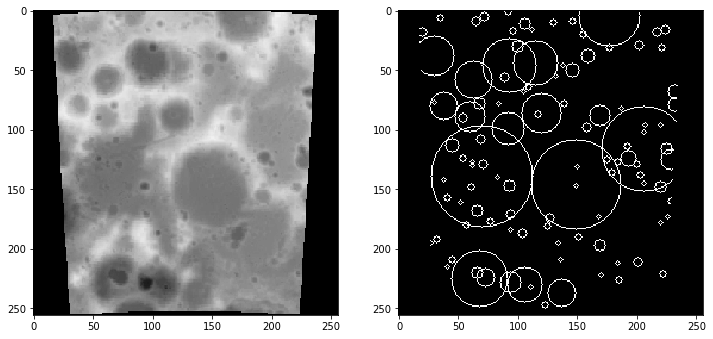

In [20]:
# Read in and pre-process data.
gen_imgs = h5py.File(zenodo_path + '/' + fn + '_images.hdf5', 'r')
sample_data = {'imgs': [gen_imgs['input_images'][...].astype('float32'),
                        gen_imgs['target_masks'][...].astype('float32')]}
proc.preprocess(sample_data)
sd_input_images = sample_data['imgs'][0]
sd_target_masks = sample_data['imgs'][1]

# Plot the data for fun.
fig = plt.figure(figsize=[12, 6])
[ax1, ax2] = fig.subplots(1,2)
ax1.imshow(sd_input_images[0].squeeze(), origin='upper', cmap='Greys_r', vmin=0, vmax=1.1)
ax2.imshow(sd_target_masks[0].squeeze(), origin='upper', cmap='Greys_r')
plt.show()

Arguments to GenDataset are listed in its docstring. To easily run GenDataset and keep track of your input arguments, see the run_input_data_gen.py script in the repo. This also uses LunarLROLrocKaguya_118mperpix.png (or any other DEM or global map); you'll have to specify its location.

In [0]:
# help(igen.GenDataset)

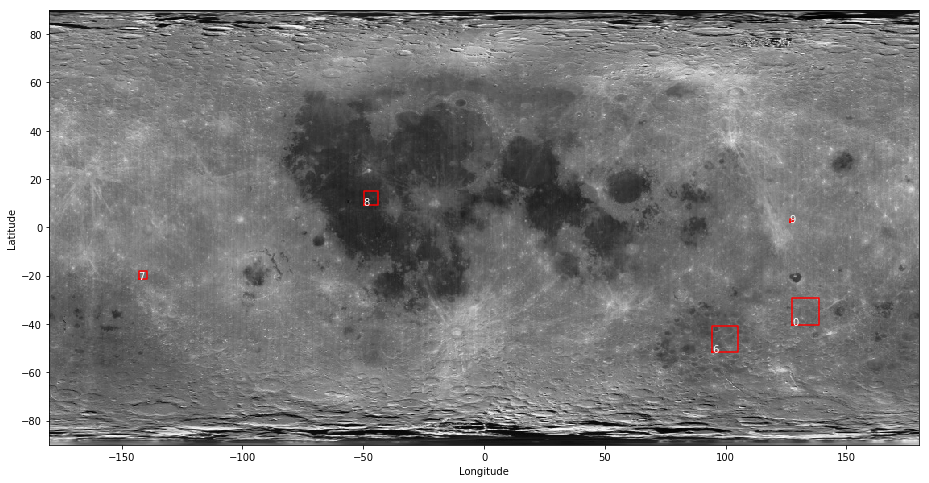

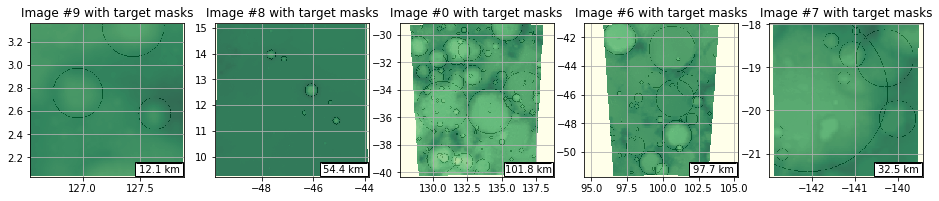

In [23]:
# (YG)
# See 5 images of the set we produced: 
show_subset = np.random.choice(range(len(gen_imgs['cll_xy'])),size=5, replace=False)
fig = plt.figure(figsize=[16, 8])
al_map = plt.imshow(albedo, extent=[-180, 180, -90, 90], aspect="equal", cmap="Greys_r")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
for i in show_subset:
  llon,rlon,llat,ulat=gen_imgs['longlat_bounds']['img_{:02d}'.format(i)][...]
  h1,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'r')
  plt.text(llon,llat,str(i), color='w')
  
def plot_map_w_scalebar2(ax,train_imgs,im_num):
  im_lims = train_imgs['longlat_bounds']['img_{:02d}'.format(im_num)][...] 
  #streching due to projection: 
#   d=np.diff(im_lims[:2])/np.cos(np.deg2rad(im_lims[2:].mean()))
#   im_lims[0]-=d/2;im_lims[1]+=d/2
  plt.imshow(train_imgs['input_images'][im_num][...], extent=im_lims, origin='upper', 
             cmap='YlGn', aspect='equal') #, vmin=50, vmax=150
  plt.imshow(1-train_imgs['target_masks'][im_num][...], alpha=0.2, extent=im_lims, 
             origin='upper', cmap='Greys_r', aspect='equal')
#   np.cos(np.deg2rad(im_lims[2:].mean()))
  plt.title('Image #{} with target masks'.format(im_num))
  l,r=plt.xlim()
  barlength = 0.3*(r-l)
  bartext = '{:2.1f} km'.format(barlength*kmperdeg)
  bar = AnchoredSizeBar(ax.transData, barlength, bartext, 4)
  ax.add_artist(bar)
  ax.grid()
  return im_lims
  
  
fig2 = plt.figure(figsize=[16, 8])
for i, im_num in enumerate(show_subset):
  ax=plt.subplot(len(show_subset)//5,5,i+1)
  plot_map_w_scalebar2(ax,gen_imgs,im_num)

# Generating Predictions From Trained Model Weights
model_keras1.2.2.h5 and model_keras2.h5 are respectively the Keras 1.2.2 and 2.0+ compatible model weights for the trained DeepMoon convolutional neural network (CNN). These can be loaded into memory using Keras's load_model module.

To train a model from scratch, see run_model_train.py.

Note: DeepMoon was train using a 16GB Tesla P100 GPU, and so the model may use prohibitive amounts of memory on systems with less GPU or system RAM.

In [24]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [25]:
from keras.models import load_model
sys.path.append("%s/utils/"%deepmoon_path)
import template_match_target as tmt

# Use the commented out line for Keras 2.0+
model = load_model(zenodo_path + '/model_keras2.h5')
# model = load_model(zenodo_path + '/model_keras1.2.2.h5')

W0625 09:34:55.025007 140485969373056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 09:34:55.072193 140485969373056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0625 09:34:55.141546 140485969373056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0625 09:34:55.251897 140485969373056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

W0625 09:34:55.257

The model can then be used to predict target masks from input images, and extract crater rings from those predictions. Let's try inserting the first image from the generated data, and then plotting the predictions and extracted rings against the ground truth target mask.

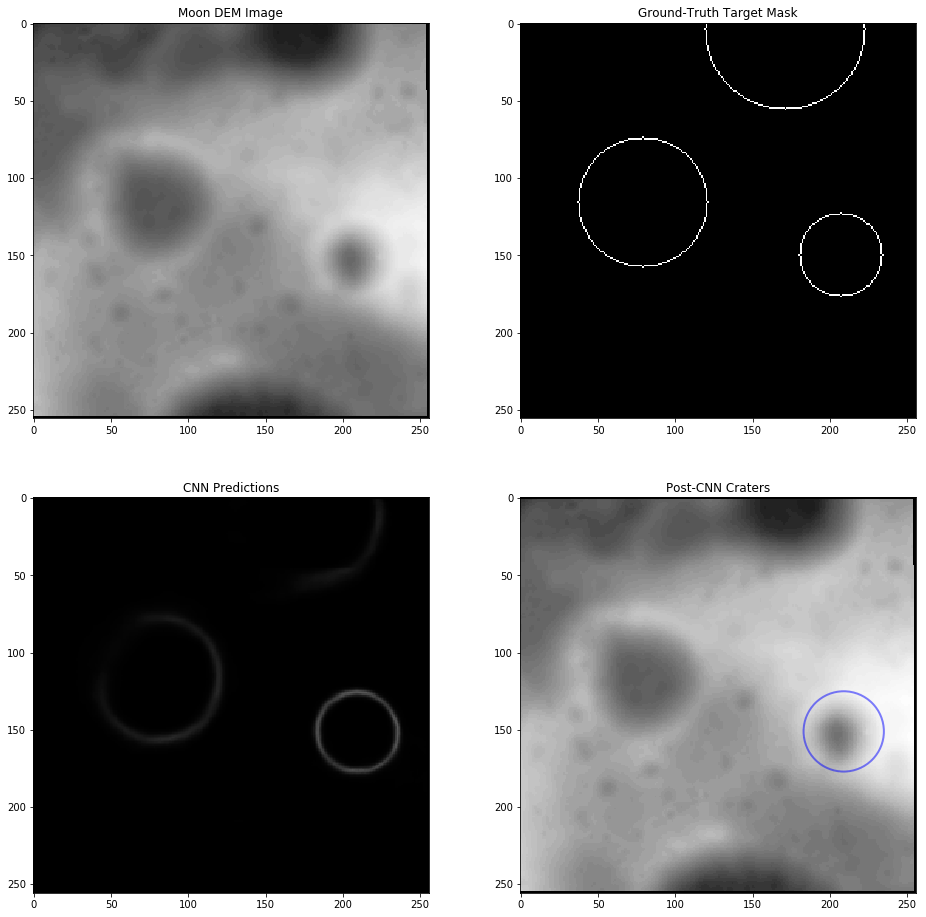

In [26]:
# Use the CNN to make a prediction.  We use [iwant:iwant + 1] to keep input as a 4D tensor.
# Input data MUST BE PREPROCESSED (see proc.preprocess, above) before being passed into model.predict
iwant = show_subset[0]
pred = model.predict(sd_input_images[iwant:iwant + 1])
# Use scikit-image template matching to extract crater locations.  Only search for craters with r >= 3 pixels.
extracted_rings = tmt.template_match_t(pred[0].copy(), minrad=3.)
#
fig = plt.figure(figsize=[16, 16])
[[ax1, ax2], [ax3, ax4]] = fig.subplots(2, 2)
ax1.imshow(sd_input_images[iwant].squeeze(), origin='upper', cmap='Greys_r', vmin=0, vmax=1.1)
ax2.imshow(sd_target_masks[iwant].squeeze(), origin='upper', cmap='Greys_r')
ax3.imshow(pred[0], origin='upper', cmap='Greys_r', vmin=0, vmax=1)
ax4.imshow(sd_input_images[iwant].squeeze(), origin='upper', cmap="Greys_r")
for x, y, r in extracted_rings:
    circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.5)
    ax4.add_artist(circle)
ax1.set_title('Moon DEM Image')
ax2.set_title('Ground-Truth Target Mask')
ax3.set_title('CNN Predictions')
ax4.set_title('Post-CNN Craters')
plt.show()

As noted from the paper, the trained CNN effectively finds craters with radii  r<15  pixels, but has trouble with larger ones (we did not search for craters with radii  r<3  pixels).

# Post-Processed Craters
post-processed_test_craters.npy contains post-processed craters from the test set (test_images.hdf5) identified by our pipeline. To make it, crater detections were aggregated from all test set DEM images, and their positions and sizes converted to longitude/latitude and kilometres. The dataset was then filtered for duplicates.

Each crater entry is arranged as a tuple: (longitude, latitude, radii), where longitude and latitude are in degrees, and radius is in kilometres.

Here we visualize extracted craters directly onto a Lunar patch using the crop_craters function.

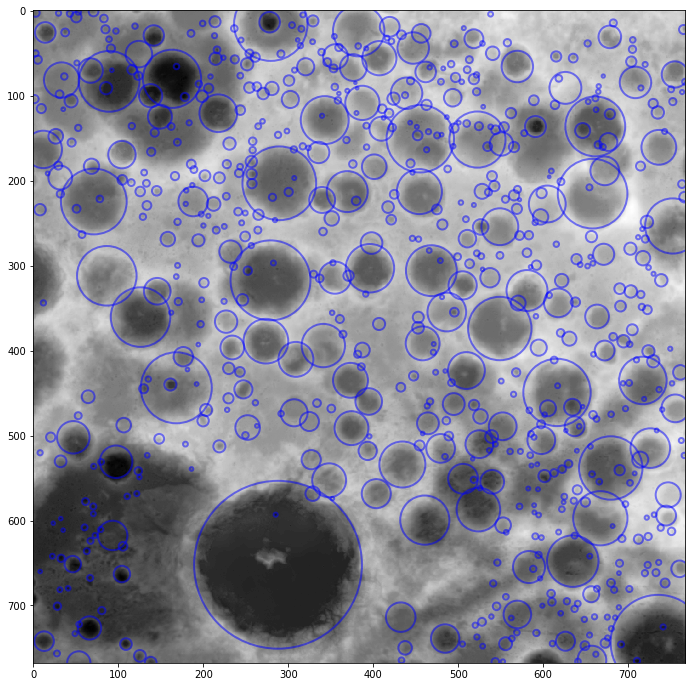

In [27]:
# Load coordinate transforms module from utils.
sys.path.append("%s/utils/"%deepmoon_path)
import transform as tfm

def crop_craters(craters, img_global, xp, yp, lenp):
    """Get desired cropped Lunar region"""
    xc = xp * img_global.size[0] / 3 + 2 * img_global.size[0] / 3
    yc = yp * img_global.size[1]
    rawlen = lenp * img_global.size[0] / 3
    
    box = np.array([xc, yc, xc + rawlen, yc + rawlen], dtype='float32')
    img_crop = img_global.crop(box)
    
    # Crop craters within bounding box, convert to pixel coordinates
    llbd = tfm.pix2coord(box[0::2], box[1::2], [-180., 180., -60., 60.], img_global.size)
    llbd = np.concatenate([llbd[0], llbd[1][::-1]])
    cLo, cLa, cR = craters[(craters.T[0] >= llbd[0]) & (craters.T[0] < llbd[1]) &
                           (craters.T[1] >= llbd[2]) & (craters.T[1] < llbd[3])].T
    x, y = tfm.coord2pix(cLo, cLa, llbd, img_crop.size)
    r = cR / ((llbd[3] - llbd[2]) * (np.pi / 180.0) * (1737.4 / (box[2] - box[0])))
    
    return np.asanyarray(img_crop), np.array(list(zip(x, y, r)))

# Load post-processed craters
craters = np.load(zenodo_path + 'post-processed_test_craters.npy')

# Dimensions of crop
longp = 0.5     # longitude coordinate as a percentage of Lunar test region (0-1 range)
latp = 0.5      # latitude coordinate as a percentage of Lunar test region (0-1 range)
lenp = 0.2      # length of cropped Lunar test region as a percentage  (0-1 range)

# Get cropped image of the Moon and corresponding cropped crater catalogue.
img_lowres = img.resize((int(img.size[0] / 8), int(img.size[1] / 8)))
img_crop, craters_crop = crop_craters(craters, img_lowres, longp, latp, lenp)

# Plot the cropped image alongside the cropped crater catalogue.
f, (ax1) = plt.subplots(1, 1, figsize=[12, 12])
ax1.imshow(img_crop, cmap='Greys_r', vmin=np.min(img_crop), vmax=np.max(img_crop))
for x, y, r in craters_crop:
    circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.5)
    ax1.add_artist(circle)
plt.show()

# DEM list
(YG)
## *1.* Original resolution (60 m/pix) Lunar DEM (SLDEM)


download from: 
http://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/sldem2015/

example tile: 
http://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/sldem2015/tiles/jp2/sldem2015_512_00n_30n_000_045.jp2

label file: 
http://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/sldem2015/tiles/jp2/sldem2015_512_00n_30n_000_045_jp2.lbl

xml file (for gDAL): 
http://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/sldem2015/tiles/jp2/sldem2015_512_00n_30n_000_045_aux.xml

These tiles  (45x30 degrees) are in a compressed format .jp2 and weigh ~180 MB each. Overall 32 tiles x 180 MB = 5.6 GB
The original tiles are in .img format and weight 1.3 GB each, or 42 GB total. 

## *2.* KAGUYA DEM (7 m/pix)

https://github.com/fermigas/ltvt/wiki/Obtaining-Kaguya-DEM-data

http://darts.isas.jaxa.jp/planet/pdap/selene/index.html.en

Global coverage of tiles 3x3 degrees. each of size 288 MB in img format. 
Overall 7,200 tile which weigh 1.97 TB
Available here: 
http://darts.isas.jaxa.jp/pub/pds3/sln-l-tc-5-dtm-map-v2.0/ 

example tile: http://darts.isas.jaxa.jp/pub/pds3/sln-l-tc-5-dtm-map-v2.0/lon000/data/DTM_MAP_02_N00E000S03E003SC.img

label file: http://darts.isas.jaxa.jp/pub/pds3/sln-l-tc-5-dtm-map-v2.0/lon000/data/DTM_MAP_02_N00E000S03E003SC.lbl 


## *3.* LROC DEM (5-2 m/pix)

463 regional data products in changing size. mostly about 0.5 deg longitude on 2 deg latitude

search engine: 
http://wms.lroc.asu.edu/lroc/rdr_product_select?filter%5Btext%5D=&filter%5Blat%5D=&filter%5Blon%5D=&filter%5Brad%5D=&filter%5Bwest%5D=&filter%5Beast%5D=&filter%5Bsouth%5D=&filter%5Bnorth%5D=&filter%5Btopographic%5D=true&filter%5Bgroup_type%5D%5B%5D=Regional+Product&filter%5Bprefix%5D%5B%5D=NAC_DTM&show_thumbs=0&per_page=10&commit=Search

heres the directory: 
http://lroc.sese.asu.edu/data/


example for one: 
http://lroc.sese.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/DATA/SDP/NAC_DTM/AESTUUM2/NAC_DTM_AESTUUM2.TIF
label file: 
http://lroc.sese.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/DATA/SDP/NAC_DTM/AESTUUM2/NAC_DTM_AESTUUM2.LBL


# Generate images set out of original lunar DEM tile (1)
(YG)


In [28]:
# download SLDEM tile: 
zenodo_path_sh='gdrive/My\ Drive/DeepMoon/zenodo_downloads/'
! wget -P $zenodo_path_sh http://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/sldem2015/tiles/jp2/sldem2015_512_00n_30n_000_045.jp2

--2019-06-25 09:37:12--  http://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/sldem2015/tiles/jp2/sldem2015_512_00n_30n_000_045.jp2
Resolving pds-geosciences.wustl.edu (pds-geosciences.wustl.edu)... 128.252.144.141
Connecting to pds-geosciences.wustl.edu (pds-geosciences.wustl.edu)|128.252.144.141|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171864155 (164M) [application/octet-stream]
Saving to: ‘gdrive/My Drive/DeepMoon/zenodo_downloads/sldem2015_512_00n_30n_000_045.jp2.1’

sldem2015_512_00n_3 100%[===================>] 163.90M  6.52MB/s    in 25s     

2019-06-25 09:37:37 (6.50 MB/s) - ‘gdrive/My Drive/DeepMoon/zenodo_downloads/sldem2015_512_00n_30n_000_045.jp2.1’ saved [171864155/171864155]



In [29]:
import input_data_gen as igen
import utils.processing as proc
zenodo_path='gdrive/My Drive/DeepMoon/zenodo_downloads/'
# Read source image.
img = Image.open(zenodo_path + "/sldem2015_512_00n_30n_000_045.jp2").convert("L")
# Read and combine the LROC and Head datasets (stored under ../catalogues)
craters = igen.ReadLROCHeadCombinedCraterCSV(filelroc=deepmoon_path + "/catalogues/LROCCraters.csv",
                                             filehead=deepmoon_path + "/catalogues/HeadCraters.csv")

fn = 'test_SLDEM1'
# Generate 'amt' image/target sets, and corresponding crater dataframes.  np.random.seed is set for consistency.
igen.GenDataset(img, craters, zenodo_path + '/' + fn, amt=10, rawlen_range=[256, 3000], cdim=[0.0, 45.0, 0.0, 30.0]) #, seed=1337

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (353894400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/content/DeepMoon/input_data_gen.py:96: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  copy=True)
/content/DeepMoon/input_data_gen.py:634: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  x, y = trf.coord2pix(craters["Long"].as_matrix(),
/content/DeepMoon/input_data_gen.py:635: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  craters["Lat"].as_matrix(),
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (92195151 pixels) exceeds limi

In [30]:
# Read in and pre-process data.
gen_imgs = h5py.File(zenodo_path + '/' + fn + '_images.hdf5', 'r')
sample_data = {'imgs': [gen_imgs['input_images'][...].astype('float32'),
                        gen_imgs['target_masks'][...].astype('float32')]}
proc.preprocess(sample_data)
sd_input_images = sample_data['imgs'][0]
sd_target_masks = sample_data['imgs'][1]


/content/DeepMoon/utils/processing.py:23: RuntimeWarning: invalid value encountered in true_divide
  img[img > 0] = low + (img[img > 0] - minn) * (hi - low) / (maxx - minn)


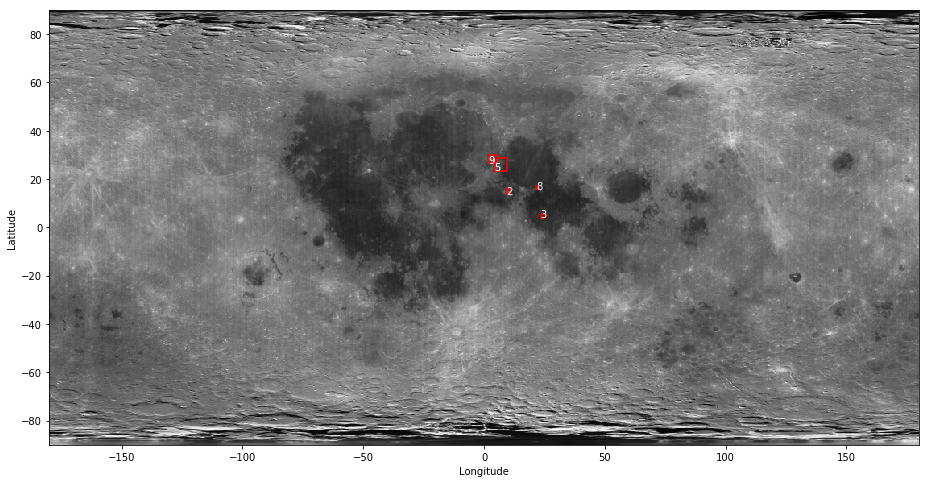

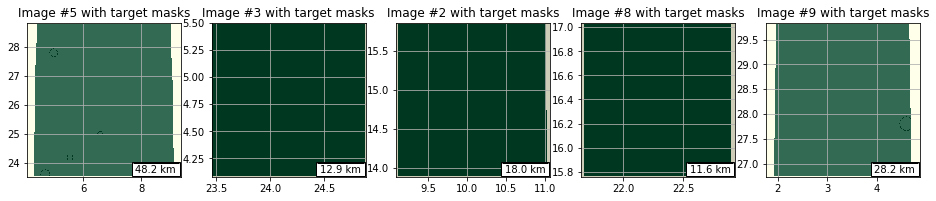

In [31]:
# See 5 images of the set we produced: 
show_subset = np.random.choice(range(len(gen_imgs['cll_xy'])),size=5, replace=False)
fig = plt.figure(figsize=[16, 8])
al_map = plt.imshow(albedo, extent=[-180, 180, -90, 90], aspect="equal", cmap="Greys_r")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
for i in show_subset:
  llon,rlon,llat,ulat=gen_imgs['longlat_bounds']['img_{:02d}'.format(i)][...]
  h1,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'r')
  plt.text(llon,llat,str(i), color='w')
  
def plot_map_w_scalebar2(ax,train_imgs,im_num):
  im_lims = train_imgs['longlat_bounds']['img_{:02d}'.format(im_num)][...] 
  #streching due to projection: 
#   d=np.diff(im_lims[:2])/np.cos(np.deg2rad(im_lims[2:].mean()))
#   im_lims[0]-=d/2;im_lims[1]+=d/2
  plt.imshow(train_imgs['input_images'][im_num][...], extent=im_lims, origin='upper', 
             cmap='YlGn', aspect='equal') #, vmin=50, vmax=150
  plt.imshow(1-train_imgs['target_masks'][im_num][...], alpha=0.2, extent=im_lims, 
             origin='upper', cmap='Greys_r', aspect='equal')
#   np.cos(np.deg2rad(im_lims[2:].mean()))
  plt.title('Image #{} with target masks'.format(im_num))
  l,r=plt.xlim()
  barlength = 0.3*(r-l)
  bartext = '{:2.1f} km'.format(barlength*kmperdeg)
  bar = AnchoredSizeBar(ax.transData, barlength, bartext, 4)
  ax.add_artist(bar)
  ax.grid()
  return im_lims
  
  
fig2 = plt.figure(figsize=[16, 8])
for i, im_num in enumerate(show_subset):
  ax=plt.subplot(len(show_subset)//5,5,i+1)
  plot_map_w_scalebar2(ax,gen_imgs,im_num)